<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Подсчет-упущенной-прибыли" data-toc-modified-id="Подсчет-упущенной-прибыли-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подсчет упущенной прибыли</a></span></li></ul></div>

# Проект "Остатки в магазинах"

# Описание проекта

Мы собираем данные каждый день по всей России по всем магазинам сетей Бристоль и Красное&Белое с учетом часовой зоны
после закрытия магазинов. В частности у нас есть данные по остаткам товаров в этих магазинах. Производителям (как нашим потенциальным клиентам) интересна выгода от продажи товаров, но часто возникает такая ситуация,
что товар в магазине закончился, а новую партию не везут, или везут но по плану в какой-то определенный день. Получается
картина при которой производитель на самом деле не дополучает прибыль. 

# Цель проекта

С помощью наших данных производитель смог бы отслеживать такие магазины (в которых заканчивается товар) и довозить туда
свою продукцию, чтобы не было пустых полок.

# Задачи

Посчитать сколько потенциально прибыли упустил производитель за выбранный период

# План работы

1. Загрузка и обработка данных
2. EDA
3. Подсчет упущенной прибыли:
- Подсчитываем средне кол-во купленных товаров по дням недели в месяце по каждому из введенных товаров
- Ищем товары и дни в магазинах по которым были нулевые остатки
- Подставляем кол-во покупаемых товаров вместо нулевых дней
- Суммируем прибыль по всем этим дням и товарам
- Умножаем на процент
- Получили общую недополученную прибыль 
4. Выводы и рекомендации заказчику

# Описание данных

- date - дата и время сбора информации
- shop_id - уникальный номер магазина
- city_name - адрес (Область, город), в котором находится магазин
- shop_address - адрес (Город, дом), в котором находится магазин
- product_id - уникальный номер продукта
- name - название пива
- measure - объем пива
- price - цена
- shop_quantity - остаток в магазине
- quantity - остаток за весь регион
- reserve_shop_quantity - резерв в магазине
- storage_quantity - объем хранения
- time_zone - часовой пояс
- barcode - ?

## Загрузка данных

Загрузка и обновление библиотек:

In [1]:
!pip install numpy==1.24.3
!pip install scipy==1.8.0
!pip install tensorflow-intel==2.16.1
!pip install --upgrade pandas matplotlib seaborn
!pip install chardet

Импорт библиотек:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings
import chardet
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Отключаем предупреждения
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("C:/Users/Кирилл/Desktop/Kirill/Data Sience/ванин проект/report_big.csv",
                 encoding='cp1251', sep=';',  parse_dates=[0])

In [5]:
display(df.head(), df.shape)
df.info()

,date,shop_id,city_name,shop_address,product_id,name,measure,price,shop_quantity,quantity,reserve_shop_quantity,storage_quantity,time_zone,barcode
0,2024-06-16 18:32:14 +0000 UTC,5041,"Оренбургская область, Энергетик п","п. Энергетик, д. 75",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,56.99,25,758683,0,1,Asia/Yekaterinburg,4600682003212
1,2024-06-28 21:25:09 +0000 UTC,23812,"Волгоградская область, Волгоград","ул. Острогожская, 26",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,51.89,38,1091865,0,1,Europe/Volgograd,4600682003212
2,2024-06-28 21:25:09 +0000 UTC,23862,"Ленинградская область, Кингисепп","ул. Октябрьская, 18А/14",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,54.89,59,1091865,0,1,Europe/Moscow,4600682003212
3,2024-06-28 21:25:09 +0000 UTC,23863,"Рязанская область, Касимов","пр-д Стадионный, 1Б",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,52.89,93,1091865,0,1,Europe/Moscow,4600682003212
4,2024-06-28 21:25:10 +0000 UTC,23874,"Чувашская Республика, Шихазаны с","ул. Генерала Михайлова, 14А",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,52.89,7,1091865,0,1,Europe/Moscow,4600682003212


(5665156, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665156 entries, 0 to 5665155
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date                   object 
 1   shop_id                int64  
 2   city_name              object 
 3   shop_address           object 
 4   product_id             int64  
 5   name                   object 
 6   measure                object 
 7   price                  float64
 8   shop_quantity          int64  
 9   quantity               int64  
 10  reserve_shop_quantity  int64  
 11  storage_quantity       int64  
 12  time_zone              object 
 13  barcode                int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 605.1+ MB


## Предобработка данных

При выгрузке, дата выгрузилась некорректно, исправим это:

In [6]:
df['date'] = pd.to_datetime(
    df['date'], format='%Y-%m-%d %H:%M:%S %z UTC'
)

display(df.head())
df.info()

,date,shop_id,city_name,shop_address,product_id,name,measure,price,shop_quantity,quantity,reserve_shop_quantity,storage_quantity,time_zone,barcode
0,2024-06-16 18:32:14+00:00,5041,"Оренбургская область, Энергетик п","п. Энергетик, д. 75",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,56.99,25,758683,0,1,Asia/Yekaterinburg,4600682003212
1,2024-06-28 21:25:09+00:00,23812,"Волгоградская область, Волгоград","ул. Острогожская, 26",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,51.89,38,1091865,0,1,Europe/Volgograd,4600682003212
2,2024-06-28 21:25:09+00:00,23862,"Ленинградская область, Кингисепп","ул. Октябрьская, 18А/14",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,54.89,59,1091865,0,1,Europe/Moscow,4600682003212
3,2024-06-28 21:25:09+00:00,23863,"Рязанская область, Касимов","пр-д Стадионный, 1Б",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,52.89,93,1091865,0,1,Europe/Moscow,4600682003212
4,2024-06-28 21:25:10+00:00,23874,"Чувашская Республика, Шихазаны с","ул. Генерала Михайлова, 14А",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,52.89,7,1091865,0,1,Europe/Moscow,4600682003212


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665156 entries, 0 to 5665155
Data columns (total 14 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   date                   datetime64[ns, UTC]
 1   shop_id                int64              
 2   city_name              object             
 3   shop_address           object             
 4   product_id             int64              
 5   name                   object             
 6   measure                object             
 7   price                  float64            
 8   shop_quantity          int64              
 9   quantity               int64              
 10  reserve_shop_quantity  int64              
 11  storage_quantity       int64              
 12  time_zone              object             
 13  barcode                int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(7), object(5)
memory usage: 605.1+ MB


Посмотрим на пропуски в датафрейме:

In [7]:
df.isna().sum()

date                     0
shop_id                  0
city_name                0
shop_address             0
product_id               0
name                     0
measure                  0
price                    0
shop_quantity            0
quantity                 0
reserve_shop_quantity    0
storage_quantity         0
time_zone                0
barcode                  0
dtype: int64

Взглянем на дубликаты:

In [8]:
df.duplicated().sum()

0

## EDA

Для анализа нужны не все столбцы, возьмем только нужные:

In [9]:
df_t = df[['date', 'shop_quantity']]

df_t.set_index('date', inplace=True)
df_t.sort_index(inplace=True)
display(df_t.head())
df_t.info()

,shop_quantity
date,
2024-06-01 11:00:02+00:00,77
2024-06-01 11:00:03+00:00,178
2024-06-01 11:00:03+00:00,33
2024-06-01 11:00:03+00:00,44
2024-06-01 11:00:03+00:00,5


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5665156 entries, 2024-06-01 11:00:02+00:00 to 2024-07-02 09:15:16+00:00
Data columns (total 1 columns):
 #   Column         Dtype
---  ------         -----
 0   shop_quantity  int64
dtypes: int64(1)
memory usage: 86.4 MB


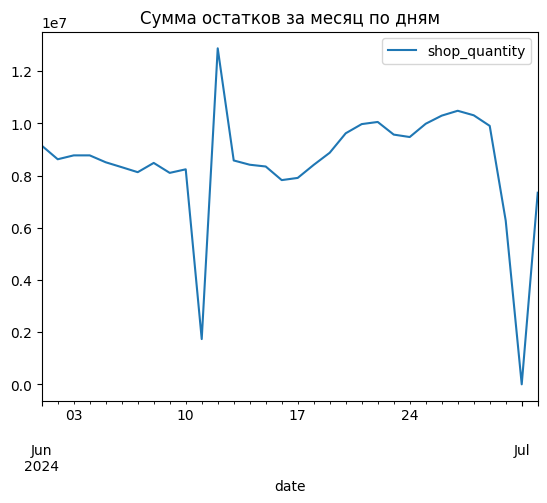

In [10]:
df_res_day = df_t.resample('1D').sum()
df_res_day.plot(title='Сумма остатков за месяц по дням');

In [11]:
df_res_day.isna().sum()
df_res_day = df_res_day.dropna()
df_res_day.isna().sum()

shop_quantity    0
dtype: int64

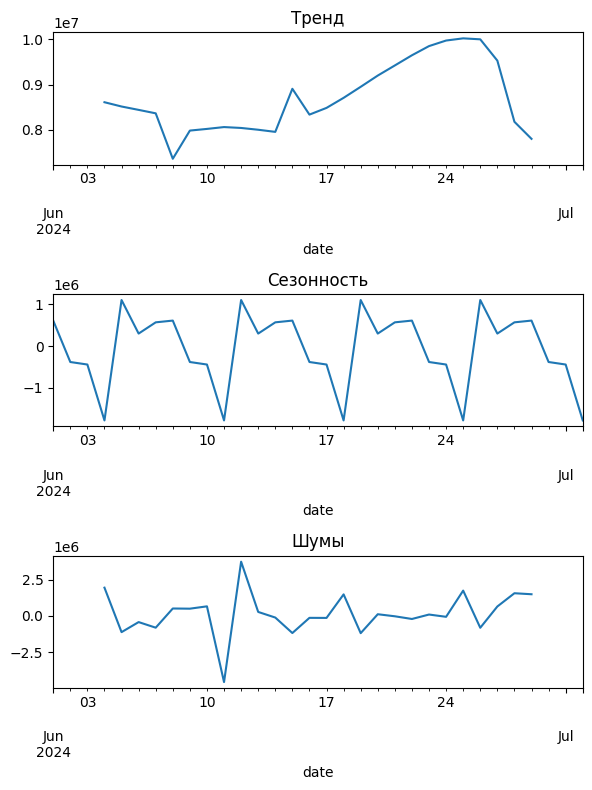

In [12]:
decomposed = seasonal_decompose(df_res_day)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шумы')
plt.tight_layout()
decomposed.resid;

Из крафика сезонности можно сделать вывод, что привоз обычно происходит посреди недели - по средам. Это логично, ведь к выходным спрос на продукт повышается. Затем выходные проходят и магазин продает остатки, дожидаясь следующего привоза. Значит в понедельник и вторник, высока вероятность того, что продукта уже не останется, соответственно магазин упускает прибыль.

## Подсчет упущенной прибыли

Для начала вычислим разницу остатков в магазине за каждый день, так мы получим количество продаж продукта за день:

In [13]:
# Преобразование столбца 'date' в datetime
df['date'] = pd.to_datetime(df['date'])

# Сортировка данных по магазину, продукту и дате
df = df.sort_values(by=['shop_id', 'product_id', 'date'])

# Вычисление ежедневных изменений в остатках
df['daily_sales'] = df.groupby(['shop_id', 'name'])['shop_quantity'].diff().fillna(0)

df.head()

,date,shop_id,city_name,shop_address,product_id,name,measure,price,shop_quantity,quantity,reserve_shop_quantity,storage_quantity,time_zone,barcode,daily_sales
39616,2024-06-01 18:11:58+00:00,20,"Челябинская область, Челябинск","ул. Гагарина, 54",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,51.89,76,625837,0,1,Asia/Yekaterinburg,4600682003212,0.0
236887,2024-06-02 18:00:12+00:00,20,"Челябинская область, Челябинск","ул. Гагарина, 54",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,51.89,66,642702,0,1,Asia/Yekaterinburg,4600682003212,-10.0
456860,2024-06-03 18:00:16+00:00,20,"Челябинская область, Челябинск","ул. Гагарина, 54",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,51.89,84,592491,0,1,Asia/Yekaterinburg,4600682003212,18.0
122180,2024-06-04 18:00:12+00:00,20,"Челябинская область, Челябинск","ул. Гагарина, 54",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,52.89,83,598535,0,1,Asia/Yekaterinburg,4600682003212,-1.0
372348,2024-06-05 18:14:36+00:00,20,"Челябинская область, Челябинск","ул. Гагарина, 54",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,52.89,82,596938,0,1,Asia/Yekaterinburg,4600682003212,-1.0


Уберем из датасета случаи, когда количество остатков на следующий день не уменьшилось, а увеличилось, это значит был привоз и сколько продали товара за этот день угадать невозможно:

In [14]:
# Фильтрация случаев, когда количество остатков увеличивается (привоз товара)
df = df[df['daily_sales'] < 0]

Сгруппируем данные по магазину и продукту, затем подсчитаем среднее количество продаж за день для каждого магазина и продукта:

In [15]:
# Вычисление продаж как модуля изменений в остатках
df['daily_sales'] = df['daily_sales'].abs()


# Группировка данных для вычисления среднего количества продаж за день
day_avg_sales = df.groupby(['shop_id', 'name'])['daily_sales'].mean().reset_index()
day_avg_sales.rename(columns={'daily_sales': 'day_avg_sales'}, inplace=True)

day_avg_sales.head()

,shop_id,name,day_avg_sales
0,20,Напиток пивной Балтика №0 Грейпфрут ж/б,4.714286
1,20,Напиток пивной Балтика №0 пшеничное ж/б,4.956522
2,20,Пиво Балтика Мягкое №7 светлое ж/б,5.750000
3,20,Пиво Балтика Мягкое №7 светлое ст,2.933333
4,20,Пиво Балтика №0 безалкогольное ж/б,6.545455


Теперь полученные средние значения подставим в те строки где в столбце shop_quantity значение 0:

In [16]:

zeros_df = df[df['shop_quantity'] == 0].copy()

zeros_df = zeros_df.merge(day_avg_sales, on=['shop_id', 'name'], how='left')

# Замена нулевых остатков на средние значения продаж
zeros_df['daily_sales'] = zeros_df['day_avg_sales']

zeros_df[['name', 'price', 'daily_sales', 'city_name', 'shop_address']].head()


,name,price,daily_sales,city_name,shop_address
0,Пиво Балтика Мягкое №7 светлое ж/б,52.89,5.166667,"Челябинская область, Златоуст","ул. Таганайская, 202"
1,Пиво Балтика №7 светлое ж/б,57.99,4.230769,"Челябинская область, Аша","ул. Ленина, 14"
2,Пиво Балтика №7 светлое ж/б,57.99,4.230769,"Челябинская область, Аша","ул. Ленина, 14"
3,Пиво Балтика №3 светлое ст,46.89,5.578947,"Челябинская область, Аша","ул. Ленина, 14"
4,Напиток пивной Балтика №0 пшеничное ж/б,52.89,9.454545,"Челябинская область, Южноуральск","ул. Советской Армии, 22а"


Вычислим упущенную прибыль:

In [17]:
# Вычисление упущенной прибыли
zeros_df['lost_profit'] = zeros_df['daily_sales'] * zeros_df['price']

display(zeros_df.head())
lose_profit = zeros_df['lost_profit'].sum()
print(f"Упущенная прибыль: {lose_profit}")

,date,shop_id,city_name,shop_address,product_id,name,measure,price,shop_quantity,quantity,reserve_shop_quantity,storage_quantity,time_zone,barcode,daily_sales,day_avg_sales,lost_profit
0,2024-06-16 18:17:14+00:00,21,"Челябинская область, Златоуст","ул. Таганайская, 202",24931,Пиво Балтика Мягкое №7 светлое ж/б,0.45 л,52.89,0,861474,0,1,Asia/Yekaterinburg,4600682024187,5.166667,5.166667,273.265000
1,2024-06-02 18:07:41+00:00,23,"Челябинская область, Аша","ул. Ленина, 14",16479,Пиво Балтика №7 светлое ж/б,0.45 л,57.99,0,1008835,0,1,Asia/Yekaterinburg,1312182000037,4.230769,4.230769,245.342308
2,2024-06-23 18:00:28+00:00,23,"Челябинская область, Аша","ул. Ленина, 14",16479,Пиво Балтика №7 светлое ж/б,0.45 л,57.99,0,297783,0,1,Asia/Yekaterinburg,1312182000037,4.230769,4.230769,245.342308
3,2024-06-29 18:00:03+00:00,23,"Челябинская область, Аша","ул. Ленина, 14",33085,Пиво Балтика №3 светлое ст,0.5 л,46.89,0,484471,0,1,Asia/Yekaterinburg,1312182000037,5.578947,5.578947,261.596842
4,2024-06-15 18:00:10+00:00,24,"Челябинская область, Южноуральск","ул. Советской Армии, 22а",19709,Напиток пивной Балтика №0 пшеничное ж/б,0.45 л,52.89,0,786156,0,1,Asia/Yekaterinburg,4600682003212,9.454545,9.454545,500.050909


Упущенная прибыль: 14199862.398711886


Посчитаем сколько реально прордали товара, для этого возьмем только те строки где количество остатков не равно 0:

In [18]:
real_df = df[df['shop_quantity'] != 0].copy()
# Вычисление упущенной прибыли
real_df['profit'] = real_df['daily_sales'] * real_df['price']

display(real_df.head())

real_profit = real_df['profit'].sum()
print(f"Реальная прибыль: {real_profit}")


,date,shop_id,city_name,shop_address,product_id,name,measure,price,shop_quantity,quantity,reserve_shop_quantity,storage_quantity,time_zone,barcode,daily_sales,profit
236887,2024-06-02 18:00:12+00:00,20,"Челябинская область, Челябинск","ул. Гагарина, 54",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,51.89,66,642702,0,1,Asia/Yekaterinburg,4600682003212,10.0,518.90
122180,2024-06-04 18:00:12+00:00,20,"Челябинская область, Челябинск","ул. Гагарина, 54",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,52.89,83,598535,0,1,Asia/Yekaterinburg,4600682003212,1.0,52.89
372348,2024-06-05 18:14:36+00:00,20,"Челябинская область, Челябинск","ул. Гагарина, 54",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,52.89,82,596938,0,1,Asia/Yekaterinburg,4600682003212,1.0,52.89
18225,2024-06-06 18:00:15+00:00,20,"Челябинская область, Челябинск","ул. Гагарина, 54",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,52.89,79,575593,0,1,Asia/Yekaterinburg,4600682003212,3.0,158.67
475067,2024-06-08 18:00:30+00:00,20,"Челябинская область, Челябинск","ул. Гагарина, 54",16477,Пиво Балтика №0 безалкогольное ж/б,0.45 л,52.79,86,546937,0,1,Asia/Yekaterinburg,4600682003212,2.0,105.58


Реальная прибыль: 819658135.5299996


Теперь можно посчитать процент упущенной прибыли:

In [19]:
sum_profit = real_profit + lose_profit

procent_lose = lose_profit * 100 / sum_profit

print(f"Процент упущенной прибыли: {procent_lose:.2f}%")

Процент упущенной прибыли: 1.70%


## Вывод

Проведенная работа показала, что производитель теряет до 2% прибыли каждый месяц.

Рекомендации:
- внедрить общую систему учета товаров
- смс (или другой вид) оповещения для магазинов куда поставляется продукция